In [1]:
from IPython.display import Image

# CNTK 101: Function Approximation Primer
This tutorial is targeted to individuals who are new to CNTK and to machine learning. In this tutorial, you will train a learning model that can be used to approximate continuious functions. See the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem). Simple models with a few neurons can approximate a wide variety of equations and Function Approximation is a powerful machine learning tool.

This notebook is for CNTK Python APIs. 

## Introduction

**Problem**:
A business has a large amount of data they wish to use in a predictive fashion. You can create a function approximation to make predictions on new data based on examples from the past. This toy example uses very simple functions for the model to approximate. It's important to understand how to get a trivial model to train well before attempting to predict more complicated models. The first model has three features (y1, y2, y3) and one label (x) where x = y (y2 and y3 are irrellevant). The model should be able to approximate x = y. The second model is slightly more complex x = 100y1+n +10y2+n +y3+n. The model should be able to approximate this easily as well. 


**Goal**:
Our goal is to learn to create a model than can approximate simple functions. We will also show you to to create and read CNTK formatted data files and how to standardize data.




In [2]:
# Figure 1
Image(url= "https://cntk.ai/jup/feedforward_network.jpg", width=200, height=300)

The figure above shows a simple feed forward network with two layers and two outputs. Our network will be even simpler with one layer and one output.

In [3]:
# Import the relevant components
import numpy as np
import os
from cntk.device import cpu, try_set_default_device
from cntk import Trainer
from cntk.learners import sgd, learning_rate_schedule, UnitType, momentum_sgd, momentum_schedule
from cntk.ops import input, sigmoid, tanh, floor, clip, relu, softplus, log
from cntk.losses import squared_error
from cntk.logging import ProgressPrinter
from cntk.io import CTFDeserializer, MinibatchSource, StreamDef, StreamDefs
from cntk.io import INFINITELY_REPEAT
from cntk.layers import Dense, Sequential

# Seed the random number generator to ensure the same dataset each time for consistency 
np.random.seed(98019)

## Input and Labels

In this tutorial we are generating synthetic data and writing it out to a CNTK formatted data file before reading it back in with CNTK tools in order to demonstrate how the data files are constructed and read.


In [4]:
def createStandardizedData(path, num_records):
    """
    Create a very simple dataset for testing regression models in the CNTK format
    Models should be able to converge quickly
    x = y1 + 0 + 0
    """
    with open(path, "w") as outfile:    
        for i in range(num_records):
            r = np.random.randint(size=(1, 1), low=0, high=999)[0][0]
            label = (r - 500) / 290 # Standardization, pre-calculated mean and standard deviation
            feature = [label, 0, 0]
            feature = [str(i) for i in feature]
            outfile.write("|labels {} |features {}\n".format(label, " ".join(feature)))


def createStandardizedData2(path, num_records):
    """
    Create a simple equation for testing regression models
    x = (y1-n) * 100 + (y2 -n) * 10 + (y3 - n)
    
    write out raw features and labels as well as a standardized set.
    Shows how models converge quickly with standardized data v.s. raw data.
    """    
    # pre-calculated. Otherwise get them from a sample of the data.
    feature_mean = 50
    feature_std_dist = 10
    label_mean = 500
    label_std_dist = 290
    with open(path, "w") as outfile:    
        for i in range(num_records):
            r = np.random.randint(size=(1, 1), low=0, high=999)[0][0]
            label = r
            standardized_label = standardize(r,label_mean, label_std_dist)
            feature = [ord(c) for c in str(r)]
            while(len(feature) < 3):
                feature.insert(0, 0)
            standardized_feature = [str(i) for i in standardize(feature, feature_mean, feature_std_dist)]
            feature = [str(i) for i in feature]
            outfile.write("|labels {} |features {} |rawlabels {} |rawfeatures {}\n".format(standardized_label, " ".join(standardized_feature), label, " ".join(feature)))

## Standardization

In order for the models to converge the variables should all have a simular range. This is a key point and if overlooked it will result in models that don't seem to be able to learn no matter what hyperparameters are tried. There are various ways to  standardize the ranges. One simple and effective method is to subtract the mean from each data point to "zero center" the data and then divide by the standard deviation to scale the data. See also [Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling)

In [5]:
def standardize(a, mean=None, std=None):
    """
    0 center and scale data
    Standardize an np.array to the array mean and standard deviation or specified parameters
    See https://en.wikipedia.org/wiki/Feature_scaling
    """
    if mean == None:
        mean = np.mean(a)
    
    if std == None:
        std = np.std(a)
    a = np.array(a, np.float32)
    n = (a - mean) / std
    return n 

## Reading CNTK data

CNTK has built in methods for reading data in the specified format. Here create_reader reads the "labels" and "features" tags, which were already standardized. create_reader_raw swaps in the raw data to run as a comparison.

In [6]:
def create_reader(path, is_training, input_dim, num_label_classes):
    """
    reads CNTK formatted file with 'labels' and 'features'
    """    
    return MinibatchSource(CTFDeserializer(path, StreamDefs(
        labels = StreamDef(field='labels', shape=num_label_classes),
        features   = StreamDef(field='features', shape=input_dim)
    )), randomize = is_training, max_sweeps = INFINITELY_REPEAT if is_training else 1)   
    
    
def create_reader_raw(path, is_training, input_dim, num_label_classes):
    """
    Reads in the unstardized values.
    """
    return MinibatchSource(CTFDeserializer(path, StreamDefs(
        labels = StreamDef(field='rawlabels', shape=num_label_classes),
        features   = StreamDef(field='rawfeatures', shape=input_dim)
    )), randomize = is_training, max_sweeps = INFINITELY_REPEAT if is_training else 1) 

## Creating the network

CNTK has an expressive and high level (layers library)[https://github.com/Microsoft/CNTK/wiki/Layers-Library-Reference]. Our simple model has a single hidden layer and one output layer. The hidden layer uses the tanh activation, sigmoid is also a good choice for this type of model. The second layer doesn't specify and activation function and will therefore output it's raw value. We can't use activations like softmax here, because they work on categories. You can try using softmax and see what it does to the model.

In [7]:
def create_model(input_dim, output_dim, hidden_dim, feature_input):    
    """
    Create a model with the layers library.
    """
    my_model = Sequential ([
            Dense(hidden_dim, tanh),
            Dense(output_dim)
            ])

    netout = my_model(feature)   
    return(netout)

Now that all the important functions have been defined we can create and test the model. First the training data is created.

In [8]:
data_file_path = r'regression_example_data.txt'
    
createStandardizedData(data_file_path, num_records =  100000) # a very simple equation
#createStandardizedData2(data_file_path, num_records = 100000) # a slightly complex equation

## Hyperparameters
 
These parameters control the overall size and shape of the model. Our model will have one hidden layer with ten neurons. The inputs and outputs are fixed for this data. The learning rate and minibatch size can be adjusted to experiment. In order for some more complicated models to work these parameters must be experimented with.

In [9]:
input_dim = 3
output_dim = 1
hidden_dim = 10
learning_rate = 0.001
minibatch_size = 120

Next we set the shape of the input and output. We also create the model, reader and map which input to use in the model to the streams in the reader.

In [10]:
 """
Input and output shapes
"""
feature = input((input_dim), np.float32)
label = input((output_dim), np.float32)

"""
Create model, reader and map
"""
netout = create_model(input_dim, output_dim, hidden_dim, feature)
training_reader = create_reader(data_file_path, True, input_dim, output_dim)
input_map = {
label  : training_reader.streams.labels,
feature  : training_reader.streams.features
}

Now we need to set the loss function. The evaluation function is optional and is used to show how well the model is predicting the data. For function approximation squared_error is a great choice. We will also set the learning rate per mini-batch. CNTK creates a schedule to optimize learning as the minibatches are run.

In [11]:
loss = squared_error(netout, label)    
evaluation = squared_error(netout, label)
lr_per_minibatch=learning_rate_schedule(learning_rate, UnitType.minibatch)

## Learning functions

CNTK has a variety of built in (learning functions)[https://www.cntk.ai/pythondocs/cntk.learners.html]. sgd is Stochastic Gradient Descent which will iteratively attempt to tune the model to match the input to the output. We pass that and the other functions to the trainer. In order to see how the model is doing we will need a progress printer that reports every n iterations.

In [12]:
learner = sgd(netout.parameters, lr=lr_per_minibatch)    

# Other learners to try
#learner = momentum_sgd(netout.parameters, lr=lr_per_minibatch, momentum = momentum_schedule(0.9))
#learner = adagrad(netout.parameters, lr=lr_per_minibatch) 
progress_printer = ProgressPrinter(minibatch_size)
trainer = Trainer(netout, (loss, evaluation), learner, progress_printer)

## Running the minibatches

Now we use CNTK to run minibatches of data through the learner. As it loops through the iterations the progress_printer will show how it's doing. We also capture the loss for later examination.

In [13]:
plotdata = {"loss":[]}
for i in range(10000):
    data = training_reader.next_minibatch(minibatch_size, input_map = input_map)
    """
    # This is how to get the Numpy typed data from the reader
    ldata = data[label].asarray()
    fdata = data[feature].asarray()
    """
    trainer.train_minibatch(data)
    loss = trainer.previous_minibatch_loss_average
    if not (loss == "NA"):
        plotdata["loss"].append(loss)       
    if np.abs(trainer.previous_minibatch_loss_average) < 0.0015: #stop once the model is good.
        break

 Minibatch[   1- 120]: loss = 1.765789 * 14400, metric = 176.58% * 14400;
 Minibatch[ 121- 240]: loss = 0.556902 * 14400, metric = 55.69% * 14400;
 Minibatch[ 241- 360]: loss = 0.181210 * 14400, metric = 18.12% * 14400;
 Minibatch[ 361- 480]: loss = 0.064498 * 14400, metric = 6.45% * 14400;
 Minibatch[ 481- 600]: loss = 0.028165 * 14400, metric = 2.82% * 14400;
 Minibatch[ 601- 720]: loss = 0.017087 * 14400, metric = 1.71% * 14400;
 Minibatch[ 721- 840]: loss = 0.013209 * 14400, metric = 1.32% * 14400;
 Minibatch[ 841- 960]: loss = 0.012035 * 14400, metric = 1.20% * 14400;
 Minibatch[ 961-1080]: loss = 0.011610 * 14400, metric = 1.16% * 14400;
 Minibatch[1081-1200]: loss = 0.011386 * 14400, metric = 1.14% * 14400;
 Minibatch[1201-1320]: loss = 0.011287 * 14400, metric = 1.13% * 14400;
 Minibatch[1321-1440]: loss = 0.011075 * 14400, metric = 1.11% * 14400;
 Minibatch[1441-1560]: loss = 0.011016 * 14400, metric = 1.10% * 14400;
 Minibatch[1561-1680]: loss = 0.010858 * 14400, metric = 1.0

## Examining the result

Now we take a look at the training summary and try out some "hold-out" data on the model to see how well it performs. We also take a peek at ten rows to see what the model came up with. _Note that in order to use the data you will have to reverse the standardization done on it previously._

In [14]:
trainer.summarize_training_progress()
test_data = training_reader.next_minibatch(minibatch_size, input_map = input_map)
avg_error = trainer.test_minibatch(test_data)
print("Error rate on an unseen minibatch %f" % avg_error)

ntldata = data[label].asarray()
ntfdata = data[feature].asarray()
for i in range(10):            
        print("data {},\tevaluation {},\texpected {}".format(
                ", ".join(str(v) for v in ntfdata[i][0]),
                netout.eval({feature: ntfdata[i]})[0],
                ntldata[i][0]))

Finished Epoch[1 of 300]: loss = 0.039021 * 1200000, metric = 3.90% * 1200000 17.619s (68108.3 samples/s);
Error rate on an unseen minibatch 0.005606
data 0.937931, 0.0, 0.0,	evaluation [ 1.01246774],	expected [ 0.93793106]
data 0.603448, 0.0, 0.0,	evaluation [ 0.68987054],	expected [ 0.60344827]
data 0.0275862, 0.0, 0.0,	evaluation [ 0.03323707],	expected [ 0.02758621]
data -0.882759, 0.0, 0.0,	evaluation [-0.96400577],	expected [-0.88275862]
data 1.63793, 0.0, 0.0,	evaluation [ 1.48890424],	expected [ 1.63793099]
data 1.08621, 0.0, 0.0,	evaluation [ 1.13622749],	expected [ 1.08620691]
data 1.55862, 0.0, 0.0,	evaluation [ 1.44824409],	expected [ 1.55862069]
data 0.67931, 0.0, 0.0,	evaluation [ 0.76795447],	expected [ 0.67931032]
data 0.793103, 0.0, 0.0,	evaluation [ 0.87984943],	expected [ 0.79310346]
data 0.851724, 0.0, 0.0,	evaluation [ 0.93489009],	expected [ 0.85172415]


In [15]:
#Figure 2
Image(url= "https://upload.wikimedia.org/wikipedia/commons/f/f3/Stogra.png")


## Graphing the loss

Visualizing the loss graph is a good way to see if your model is performing correctly. The above figure shows a typical loss progression for models that converge properly.
Here we will smooth our loss data and examine a graph to see how well the model is converging.

In [16]:
# import pyplot and define a moving average function
import matplotlib.pyplot as plt
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

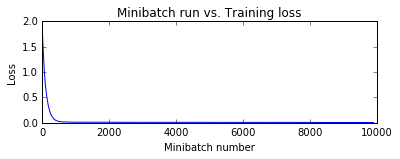

In [17]:
# plot the data
plotdata["avgloss"] = moving_average(plotdata["loss"], 100)
plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["avgloss"])
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')
plt.show()

## Suggestions

  - Go back and run the model with the both data types and compare the loss rate.
  - Try the different learners and compare the loss rate.
  - Use create_reader_raw to pass in non-standardized data to the model and compare the learning rate.